# Self-Driving Car Engineer Nanodegree


## Project: Build a Traffic Sign Recognition Classifier

The following code is to make a LeNet based Traffic Sign Classfier from scratch using TensorFlow. Please go through the ReadMe for install instructions and other relevant information. 

#### Import all the libraries

In [80]:
import urllib.request 
import os
import zipfile
import cv2 
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import random
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import matplotlib.image as mpimg
import glob

## Step 0: Load The Data

In [1]:
# The following code section will create a directory with 
# the loaded dataset outside your code directory


print("Dataset download started")

url = 'https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip'
dirName = "../dataset"
   
# Create target Directory if don't exist
if not os.path.exists(dirName):
    os.mkdir(dirName)
    print("Dataset directory created")
else:    
    print("Dataset directory already exists")

print("Downloading dataset, please wait..")
    
urllib.request.urlretrieve(url, '../dataset/dataset.zip')  

print("Dataset download finished ")

zip_ref = zipfile.ZipFile(dirName+'/dataset.zip', 'r')
zip_ref.extractall(dirName)
zip_ref.close()
os.remove(dirName+'/dataset.zip')

print("Dataset is now ready to be used")

Dataset download started
Dataset directory already exists
Dataset download finished 
Dataset is now ready to be used


In [2]:
# Load pickled data

#have put the dataset outside Project folder
traffic_signs_data_folder = '../dataset/' 
training_file = traffic_signs_data_folder + 'train.p'
validation_file= traffic_signs_data_folder + 'valid.p'
testing_file = traffic_signs_data_folder + 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print ('Data loaded in Python')

Data loaded in Python


---

## Step 1: Dataset Summary & Exploration


In [70]:
# Making sure that the dataset is proper
assert (len(X_train) == len(y_train))
assert (len(X_valid) == len(y_valid))
assert (len(X_test)  == len(y_test))

# Number of training examples
n_train = len(y_train)

# Number of validation examples
n_validation = len(y_valid)

# Number of testing examples.
n_test = len(y_test)

# What's the shape of an traffic sign image
image_shape = X_train[0].shape

# Number of unique classes in dataset.
n_classes = np.unique(y_train).size

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

2


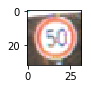

In [71]:
# Visualizations will be shown in the notebook.
%matplotlib inline

for index in range(100,101):
    image = X_train[index]
    plt.figure(figsize=(1,1))
    plt.imshow(image)
    print(y_train[index])

In [72]:
# But what is that number in the above code block?
%matplotlib inline

classId2SignName = {}

with open('signnames.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        classId2SignName[row[0]] = row[1]
    
def visualizeImages(images,labels):
    n_columns = 8
    n_rows = int(len(images)/n_columns)+1
    width = 24
    height = n_rows * 3
    fig, axs = plt.subplots(n_rows,n_columns, figsize=(width, height))
    fig.subplots_adjust(hspace = .2, wspace=.1)
    axs = axs.ravel()
    for i in range(n_columns * n_rows):
        axs[i].axis('off')
        if (i<len(images)):
            image = images[i]
            axs[i].axis('off')
            axs[i].imshow(image)
            axs[i].set_title('{} ({:.20})'.format(labels[i], classId2SignName[str(labels[i])]))

data = pd.read_csv("signnames.csv")

The following figures are the representation of all the 43 classes of the Dataset


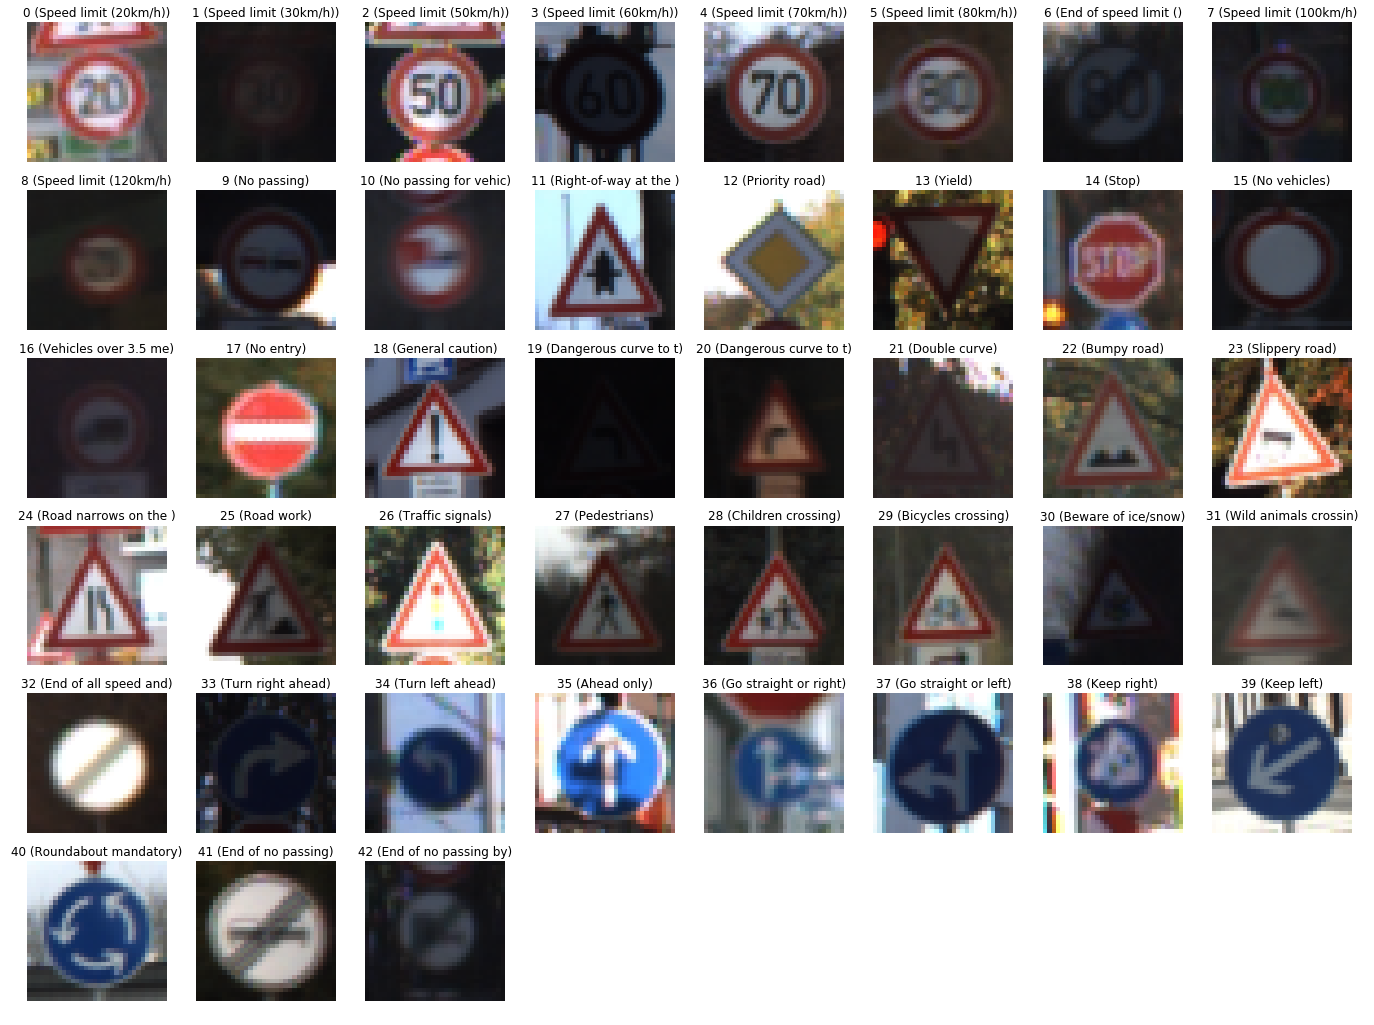

In [74]:
X = [] 
Y = []

labels, indices = np.unique(y_train, return_index=True)
for i in range(len(labels)):
    X.append(X_train[indices[i]])
    Y.append(labels[i])
        
visualizeImages(X,Y)

print ("The following figures are the representation of all the 43 classes of the Dataset")


In [77]:
print("These are all the classes in the dataset that we are using")
data

These are all the classes in the dataset that we are using


,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


This is the chart for number of images in each class


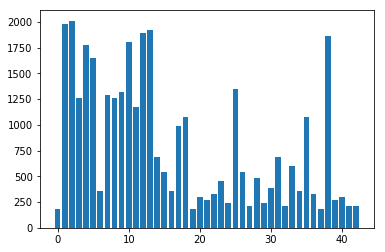

In [78]:
x,y = np.unique(y_train, return_counts=True)
plt.bar(x,y)
plt.show

print ('This is the chart for number of images in each class')

----

## Step 2: Design and Test a Model Architecture


### Pre-process the Data Set 

In [9]:
def preProcess(color_images):
    # grayscale
    grayscaled_images = np.sum(color_images/3, axis=3, keepdims=True)
    
    # normalize
    normalized_images = (grayscaled_images - 128) / 128
    
    
    return normalized_images

In [10]:
def getRandomImage(x, y, filter_index):
    indices, = np.nonzero( y==filter_index )
    index = np.random.choice(indices)
    return x[index]
    

image = getRandomImage(X_train, y_train, 23)

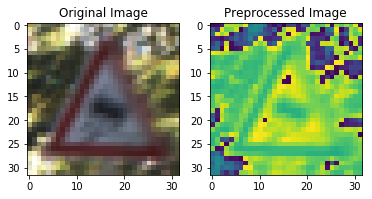

Shape of Original image: (34799, 32, 32, 3)
Shape of preprocessed image: (34799, 32, 32, 1)


In [11]:
preprocessed = preProcess(X_train)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
normalized_image = (gray - 128) / 128

f = plt.figure()

f1=f.add_subplot(1,2, 1)
f1.set_title('Original Image')
plt.imshow(image)

f2=f.add_subplot(1,2, 2)
f2.set_title('Preprocessed Image')
plt.imshow(normalized_image)

plt.show(block=True)


print ("Shape of Original image:",X_train.shape)
print ("Shape of preprocessed image:",preprocessed.shape)


## Model Architecture

### Shuffling of Dataset

In [12]:
X_train, y_train = shuffle(X_train, y_train)

In [13]:
# Defining TensorFlow parameter


In [14]:
# Defining TensorFlow variables 

keep_prob = tf.placeholder(tf.float32)
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32)


In [15]:
# My modiefied version of LeNet

def LeNet_modified(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(2, 2, 1, 10), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(10))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Layer 1: Activation.
    conv1 = tf.nn.relu(conv1)

    # Layer 1: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(2, 2,10, 20), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(20))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Layer 2: Activation.
    conv2 = tf.nn.relu(conv2)

    # Layer 2: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    fc0   = tf.nn.dropout(fc0, keep_prob)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(980, 400), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(400))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Layer 3: Activation.
    fc1    = tf.nn.relu(fc1)
    fc1    = tf.nn.dropout(fc1, keep_prob) 


    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(400, 180), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(180))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Layer 4: Activation.
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2, keep_prob) 

    
    
    # Layer 5: Fully Connected. Input = 150. Output = 80.
    
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(180, 80), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(80))
    fc3    = tf.matmul(fc2, fc3_W) + fc3_b
    
    # Layer 5: Activation.
    fc3    = tf.nn.relu(fc3)
    fc3    = tf.nn.dropout(fc3, keep_prob) 
    
    
    
    # Layer 6: Fully Connected. Input = 80. Output = 43.
    fc4_W  = tf.Variable(tf.truncated_normal(shape=(80, 43), mean = mu, stddev = sigma))
    fc4_b  = tf.Variable(tf.zeros(43))


    logits = tf.matmul(fc3, fc4_W) + fc4_b
    
    return logits

### Experiment

In [16]:
def DeepNetMergeLayers(x, dropout_keep_prob):
    mu = 0
    sigma = 0.1

    conv1, num_output_filters = convolutional_layer(x, num_input_filters=1, num_output_filters=3,
                                                    filter_shape=(1, 1), strides=[1,1,1,1], padding='SAME',
                                                    mean=mu, stddev=sigma, activation_func=tf.nn.relu, name="conv2d_1")


    # Group 1
    conv2, num_output_filters = convolutional_layer(conv1, num_input_filters=num_output_filters, num_output_filters=8,
                                                    filter_shape=(5, 5), strides=[1,1,1,1], padding='SAME',
                                                    mean=mu, stddev=sigma, activation_func=tf.nn.relu, name="conv2d_2")

    conv3, num_output_filters = convolutional_layer(conv2, num_input_filters=num_output_filters, num_output_filters=8,
                                                    filter_shape=(5, 5), strides=[1,1,1,1], padding='SAME',
                                                    mean=mu, stddev=sigma, activation_func=tf.nn.relu, name="conv2d_3")

    maxpool1 = maxpool2d(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name="maxpool1")

    dropout1 = tf.nn.dropout(maxpool1, dropout_keep_prob, name="dropout1")

    # Group 2
    conv4, num_output_filters = convolutional_layer(dropout1, num_input_filters=num_output_filters, num_output_filters=16,
                                                    filter_shape=(5, 5), strides=[1,1,1,1], padding='SAME',
                                                    mean=mu, stddev=sigma, activation_func=tf.nn.relu, name="conv2d_4")

    conv5, num_output_filters = convolutional_layer(conv4, num_input_filters=num_output_filters, num_output_filters=16,
                                                    filter_shape=(5, 5), strides=[1,1,1,1], padding='SAME',
                                                    mean=mu, stddev=sigma, activation_func=tf.nn.relu, name="conv2d_5")

    maxpool2 = maxpool2d(conv5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name="maxpool2")

    dropout2 = tf.nn.dropout(maxpool2, dropout_keep_prob, name="dropout2")

    # Group 3
    conv6, num_output_filters = convolutional_layer(dropout2, num_input_filters=num_output_filters, num_output_filters=32,
                                                    filter_shape=(5, 5), strides=[1,1,1,1], padding='SAME',
                                                    mean=mu, stddev=sigma, activation_func=tf.nn.relu, name="conv2d_6")

    conv7, num_output_filters = convolutional_layer(conv6, num_input_filters=num_output_filters, num_output_filters=32,
                                                    filter_shape=(5, 5), strides=[1,1,1,1], padding='SAME',
                                                    mean=mu, stddev=sigma, activation_func=tf.nn.relu, name="conv2d_6")

    maxpool3 = maxpool2d(conv7, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name="maxpool3")

    dropout3 = tf.nn.dropout(maxpool3, dropout_keep_prob, name="dropout3")

    # Now Flatten all the layers together
    layer_flat_group1, num_fc_layers_group1 = flatten_layer(dropout1)
    layer_flat_group2, num_fc_layers_group2 = flatten_layer(dropout2)
    layer_flat_group3, num_fc_layers_group3 = flatten_layer(dropout3)
    layer_flat = tf.concat(values=[layer_flat_group1, layer_flat_group2, layer_flat_group3], axis=1)

    num_fc_layers = num_fc_layers_group1 + num_fc_layers_group2 + num_fc_layers_group3

    fc_size1 = 1024
    ## FC_size
    fc_size2 = 1024

    # Fully Connected: Input = 1024               Output = 1024
    fc1, output_size = fully_connected_layer(layer_flat, num_fc_layers, num_fc_layers, mu, sigma,
                                             activation_func=tf.nn.relu, dropout_prob=dropout_keep_prob, name="fc1")

    fc2, output_size = fully_connected_layer(fc1, num_fc_layers, num_fc_layers, mu, sigma,
                                             activation_func=tf.nn.relu, dropout_prob=dropout_keep_prob, name="fc2")

    # Fully Connected: Input = 96               Output = 43
    logits, _ = fully_connected_layer(fc1, num_fc_layers, 43, mu, sigma,
                                      activation_func=None, dropout_prob=1.0, name="logits")

    return logits


In [17]:
def DeepNet(x, dropout_keep_prob):
    # Hyper parameters
    mu = 0
    sigma = 0.1

    one_by_one, num_output_filters = convolutional_layer(x, num_input_filters=1, num_output_filters=3,
                                                        filter_shape=(1, 1), strides=[1,1,1,1], padding='SAME',
                                                        mean=mu, stddev=sigma, activation_func=tf.nn.relu, name="conv2d_1")

    # Convolutional Layer 1: Input 32x32x3         Output = 32x32x12
    conv1, num_output_filters = convolutional_layer(one_by_one, num_input_filters=3, num_output_filters=12,
                                                    filter_shape=(3, 3), strides=[1,1,1,1], padding='SAME',
                                                    mean=mu, stddev=sigma, activation_func=tf.nn.relu, name="conv2d_1")

    # Convolutional Layer 2: Input 32x32x12         Output = 28x28x24
    conv2, num_output_filters = convolutional_layer(conv1, num_input_filters=num_output_filters, num_output_filters=num_output_filters * 2,
                                                    filter_shape=(5, 5), strides=[1,1,1,1], padding='VALID',
                                                    mean=mu, stddev=sigma, activation_func=tf.nn.relu, name="conv2d_2")

    # Convolutional Layer 3: Input 28x28x24         Output = 24x24x48
    conv3, num_output_filters = convolutional_layer(conv2, num_input_filters=num_output_filters, num_output_filters=num_output_filters * 2,
                                                    filter_shape=(5, 5), strides=[1,1,1,1], padding='VALID',
                                                    mean=mu, stddev=sigma, activation_func=tf.nn.relu, name="conv2d_3")

    # Convolutional Layer 4: Input 24x24x48         Output = 16x16x96
    conv4, num_output_filters = convolutional_layer(conv3, num_input_filters=num_output_filters, num_output_filters=num_output_filters * 2,
                                                    filter_shape=(9, 9), strides=[1,1,1,1], padding='VALID',
                                                    mean=mu, stddev=sigma, activation_func=tf.nn.relu, name="conv2d_4")

    # Now lets add Convolutional Layers with downsampling
    conv5, num_output_filters = convolutional_layer(conv4, num_input_filters=num_output_filters, num_output_filters=num_output_filters * 2,
                                                    filter_shape=(3, 3), strides=[1,1,1,1], padding='SAME',
                                                    mean=mu, stddev=sigma, activation_func=tf.nn.relu, name="conv2d_5")

    # MaxPool Layer: Input 16x16x192                 Output = 16x16x384
    maxpool1 = tf.nn.max_pool(conv5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name="maxpool1")

    # Convolutional Layer 6: Input 16x16x384         Output = 8x8x384
    conv6, num_output_filters = convolutional_layer(maxpool1, num_input_filters=num_output_filters, num_output_filters=num_output_filters * 2,
                                                    filter_shape=(11, 11), strides=[1,1,1,1], padding='SAME',
                                                    mean=mu, stddev=sigma, activation_func=tf.nn.relu, name="conv2d_6")

    # MaxPool Layer: Input 8x8x384                 Output = 4x4x384
    maxpool2 = tf.nn.max_pool(conv6, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name="maxpool2")

    # Fully Connected Layer
    fc0 = flatten(maxpool2)

    # Fully Connected: Input = 6144                Output = 3072
    fc1, output_size = fully_connected_layer(fc0, 6144, 3072, mu, sigma, tf.nn.relu, dropout_keep_prob, name="fc1")

    # Fully Connected: Input = 3072                Output = 1536
    fc2, output_size = fully_connected_layer(fc1, 3072, 1536, mu, sigma, tf.nn.relu, dropout_keep_prob, name="fc2")

    # Fully Connected: Input = 1536               Output = 768
    fc3, output_size = fully_connected_layer(fc2, 1536, 768, mu, sigma, tf.nn.relu, dropout_keep_prob, name="fc3")


    # Fully Connected: Input = 768               Output = 384
    fc4, output_size = fully_connected_layer(fc3, 768, 384, mu, sigma, tf.nn.relu, dropout_keep_prob, name="fc4")

    # Fully Connected: Input = 384               Output = 192
    fc5, output_size = fully_connected_layer(fc4, 384, 192, mu, sigma, tf.nn.relu, dropout_keep_prob, name="fc5")

    # Fully Connected: Input = 192               Output = 96
    fc6, output_size = fully_connected_layer(fc5, 192, 96, mu, sigma, tf.nn.relu, dropout_keep_prob, name="fc6")

    # Fully Connected: Input = 96               Output = 43
    # logits, output_size = fully_connected_layer(fc6, 96, 43, mu, sigma, tf.nn.relu, dropout_keep_prob, name="logits")
    logits, output_size = fully_connected_layer(fc6, 96, 43, mu, sigma,
                                                activation_func=None, dropout_prob=1.0, name="logits")
    return logits

In [18]:
def convolutional_layer(input, num_input_filters, num_output_filters, filter_shape,
                        strides, padding, mean, stddev, activation_func=None, name=""):
    conv_W = tf.Variable(tf.truncated_normal(shape=filter_shape+(num_input_filters, num_output_filters), mean=mean, stddev=stddev), name+"_weights")
    conv_b = tf.Variable(tf.zeros(num_output_filters), name=name+"_bias")

    conv = tf.nn.conv2d(input, conv_W, strides, padding) + conv_b

    # Activation Layer
    if activation_func is not None:
        conv = activation_func(conv)

    print(name + ": " + str(conv.get_shape().as_list()))
    return conv, num_output_filters


def fully_connected_layer(input, input_size, output_size, mean, stddev,
                          activation_func, dropout_prob, name):
    fc_W = tf.Variable(tf.truncated_normal(shape=(input_size, output_size),
                       mean=mean, stddev=stddev), name=name + "_W")
    fc_b = tf.Variable(tf.zeros(output_size), name=name + "_b")
    fc   = tf.matmul(input, fc_W) + fc_b

    if activation_func is not None:
        fc = activation_func(fc, name=name + "_relu")

    fc = tf.nn.dropout(fc, dropout_prob)

    return fc, output_size


def maxpool2d(input, ksize, strides, padding, name=""):
    maxpool = tf.nn.max_pool(input, ksize, strides, padding, name=name)

    return maxpool

def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

In [19]:
rate = 0.001

logits = LeNet_modified(x)
# logits = DeepNet(x,0.5)
# logits = DeepNetMergeLayers(x, 0.5)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [20]:
# PreProcess the dataset

X_train_preProcessed = preProcess(X_train)
X_valid_preProcessed = preProcess(X_valid)
X_test_preProcessed  = preProcess(X_test)

print("Finished Preprocessing")

Finished Preprocessing


### Training session

Training...

EPOCH 1 ...
Training Accuracy = 0.120
Validation Accuracy = 0.088

EPOCH 2 ...
Training Accuracy = 0.243
Validation Accuracy = 0.203

EPOCH 3 ...
Training Accuracy = 0.396
Validation Accuracy = 0.338

EPOCH 4 ...
Training Accuracy = 0.496
Validation Accuracy = 0.441

EPOCH 5 ...
Training Accuracy = 0.577
Validation Accuracy = 0.504

EPOCH 6 ...
Training Accuracy = 0.648
Validation Accuracy = 0.586

EPOCH 7 ...
Training Accuracy = 0.698
Validation Accuracy = 0.639

EPOCH 8 ...
Training Accuracy = 0.752
Validation Accuracy = 0.687

EPOCH 9 ...
Training Accuracy = 0.791
Validation Accuracy = 0.755

EPOCH 10 ...
Training Accuracy = 0.812
Validation Accuracy = 0.760

EPOCH 11 ...
Training Accuracy = 0.831
Validation Accuracy = 0.778

EPOCH 12 ...
Training Accuracy = 0.853
Validation Accuracy = 0.793

EPOCH 13 ...
Training Accuracy = 0.853
Validation Accuracy = 0.795

EPOCH 14 ...
Training Accuracy = 0.863
Validation Accuracy = 0.809

EPOCH 15 ...
Training Accuracy = 0.890
Valid

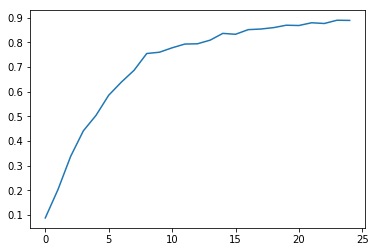

In [21]:
EPOCHS = 25
BATCH_SIZE = 512
DROPOUT = 0.5


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    validation_accuracies = []
    
    for i in range(EPOCHS):
        X_train, X_train_preProcessed, y_train = shuffle(X_train, X_train_preProcessed, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_preProcessed[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: DROPOUT})
            
        training_accuracy = evaluate(X_train_preProcessed, y_train)
        validation_accuracy = evaluate(X_valid_preProcessed, y_valid)
        
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        validation_accuracies.append(validation_accuracy)
        
    saver.save(sess, './lenet')
    
    # show learning statistics
    plt.plot(range(EPOCHS),validation_accuracies)
    plt.show
    
    print("Model saved")

In [22]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    test_accuracy = evaluate(X_test_preProcessed, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.873


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

Done


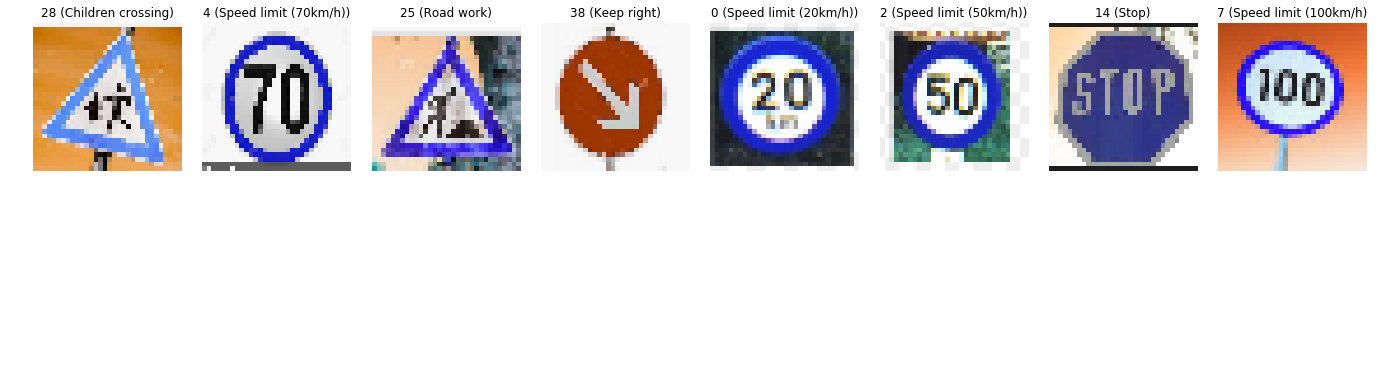

In [23]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
traffic_signs_data_folder = 'test_data/'
    
my_X_test = []
my_Y_test = []

for image_file in glob.glob(traffic_signs_data_folder + "*.png"):
    img = cv2.imread(image_file)
    img = cv2.resize(img, (32, 32))
    
    try:
        if (True):
        # the label is encoded into the first two characters of the file names
            label_str = image_file[len(traffic_signs_data_folder):][:2]
            label = int(label_str)
            my_X_test.append(img)
            my_Y_test.append(label)
    except  Exception:
        print ('Ignoring image {}'.format(image_file))


visualizeImages(my_X_test, my_Y_test)

print ('Done')

### Predict the Sign Type for Each Image

INFO:tensorflow:Restoring parameters from ./lenet
[28  4 25 38  1  2 14  1]


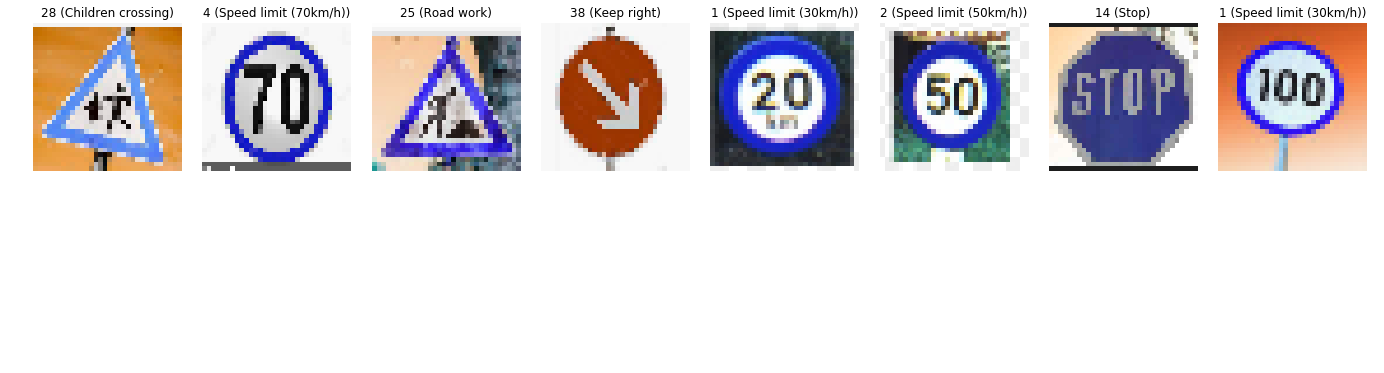

In [24]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

my_X_test_preProcessed = preProcess(np.array(my_X_test))

prediction=tf.argmax(logits,1)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    predictions = sess.run(prediction, feed_dict={x: my_X_test_preProcessed, keep_prob: 1.0})
    visualizeImages(my_X_test, predictions)
    
    print (predictions)

### Analyze Performance

In [25]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    test_accuracy = evaluate(my_X_test_preProcessed, my_Y_test)
    print("Custom Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Custom Test Accuracy = 0.750


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [26]:
def visualizeTop_k(test_images, train_images, top_k):
    probabilities = top_k.values
    indices = top_k.indices
    assert (len(test_images) == len(indices))
          
    n_columns = 6
    n_rows = len(indices)
    width = 24
    height = n_rows * 3
    fig, axs = plt.subplots(n_rows,n_columns, figsize=(width, height))
    fig.subplots_adjust(hspace = .2, wspace=.1)
    axs = axs.ravel()
    i = 0
    for row in range(n_rows):
        axs[i].axis('off')
        axs[i].imshow(test_images[row])
        #axs[i].set_title('{} ({:.20})'.format(labels[i], classId2SignName[str(labels[i])]))
        i += 1
        for j in range(len(indices[row])):
            index = indices[row][j]
            probability = probabilities[row][j]
            axs[i].axis('off')
            axs[i].set_title('{:.2f}% ({} {:.20})'.format(probability*100, index,  classId2SignName[str(index)]))
            axs[i].imshow(getRandomImage(X_train, y_train, index))
            i += 1

In [27]:
def visualizeTop_k2(test_images, train_images, top_k):
    probabilities = top_k.values
    indices = top_k.indices
    assert (len(test_images) == len(indices))
          
    n_columns = 2
    n_rows = len(indices)
    width = 24
    height = n_rows * 3
    fig, axs = plt.subplots(n_rows,n_columns, figsize=(width, height))
    fig.subplots_adjust(hspace = .2, wspace=.1)
    axs = axs.ravel()
    i = 0
    for row in range(n_rows):
        axs[i].axis('off')
        axs[i].imshow(test_images[row])
        i += 1
        labs=[classId2SignName[str(j)] for j in indices[row]]
        axs[i].barh(labs, probabilities[row])
        
        #axs[i].yticks(np.arange(1, 6, 1), labs)
        i += 1

INFO:tensorflow:Restoring parameters from ./lenet
done


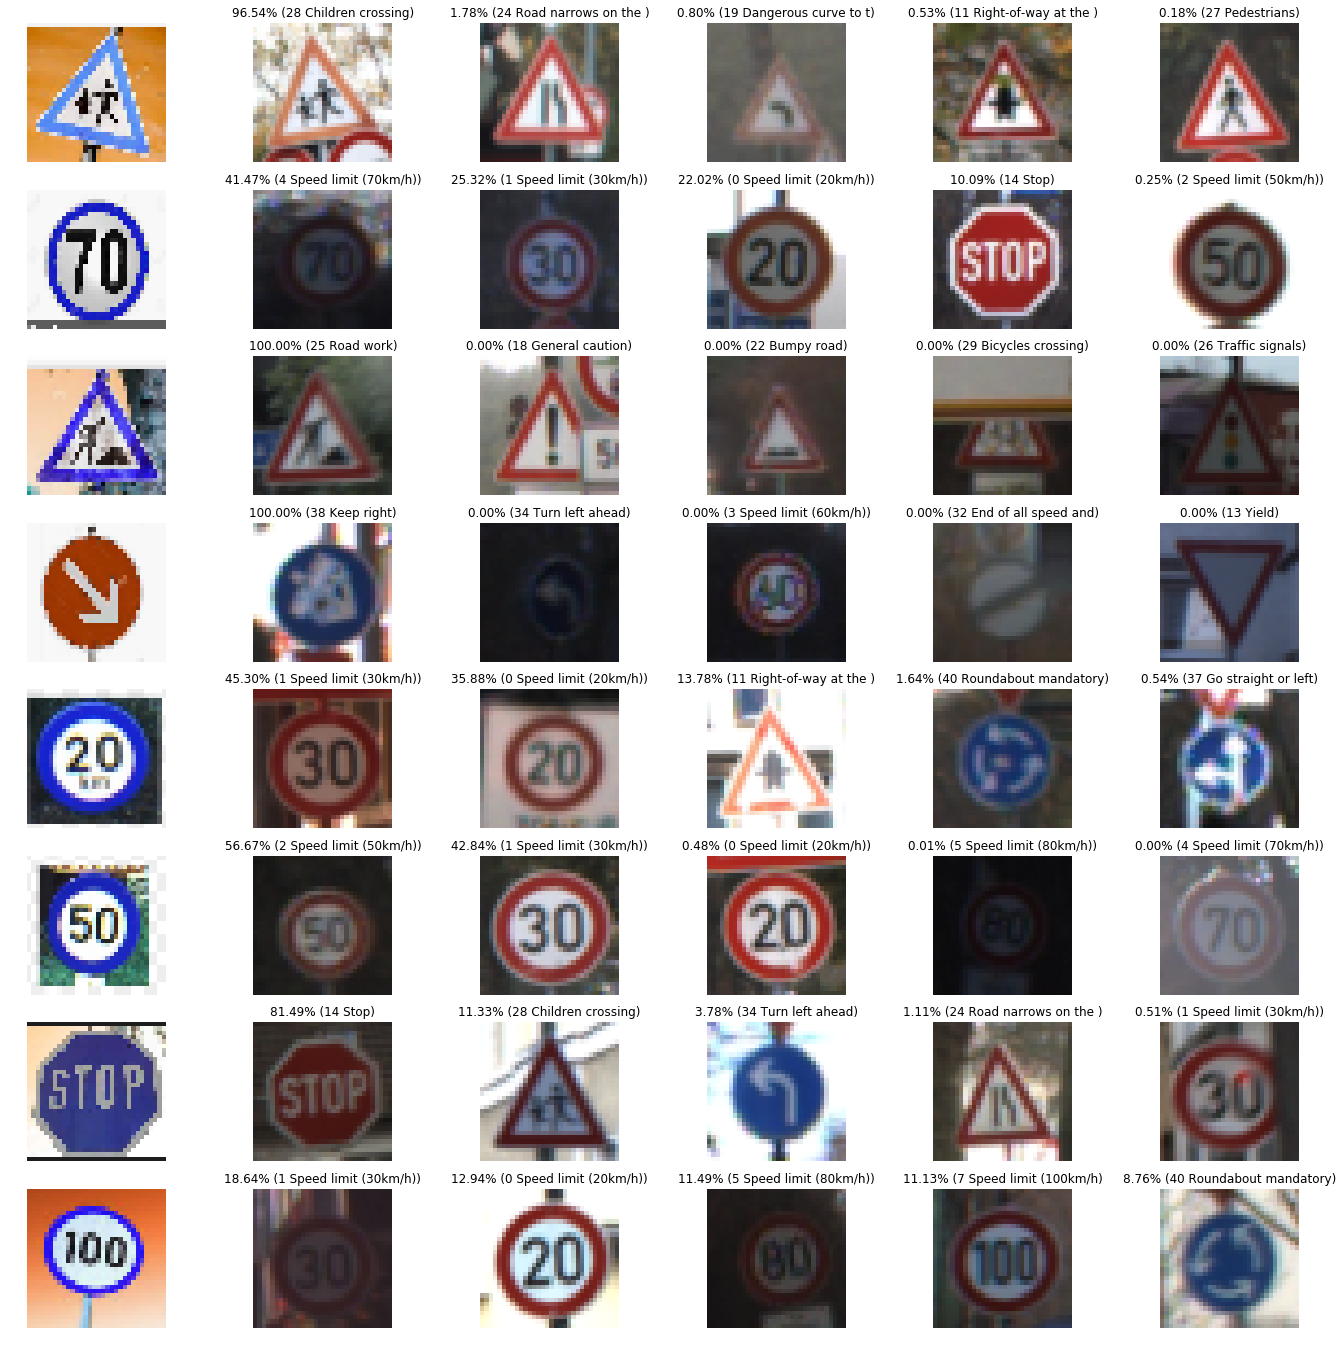

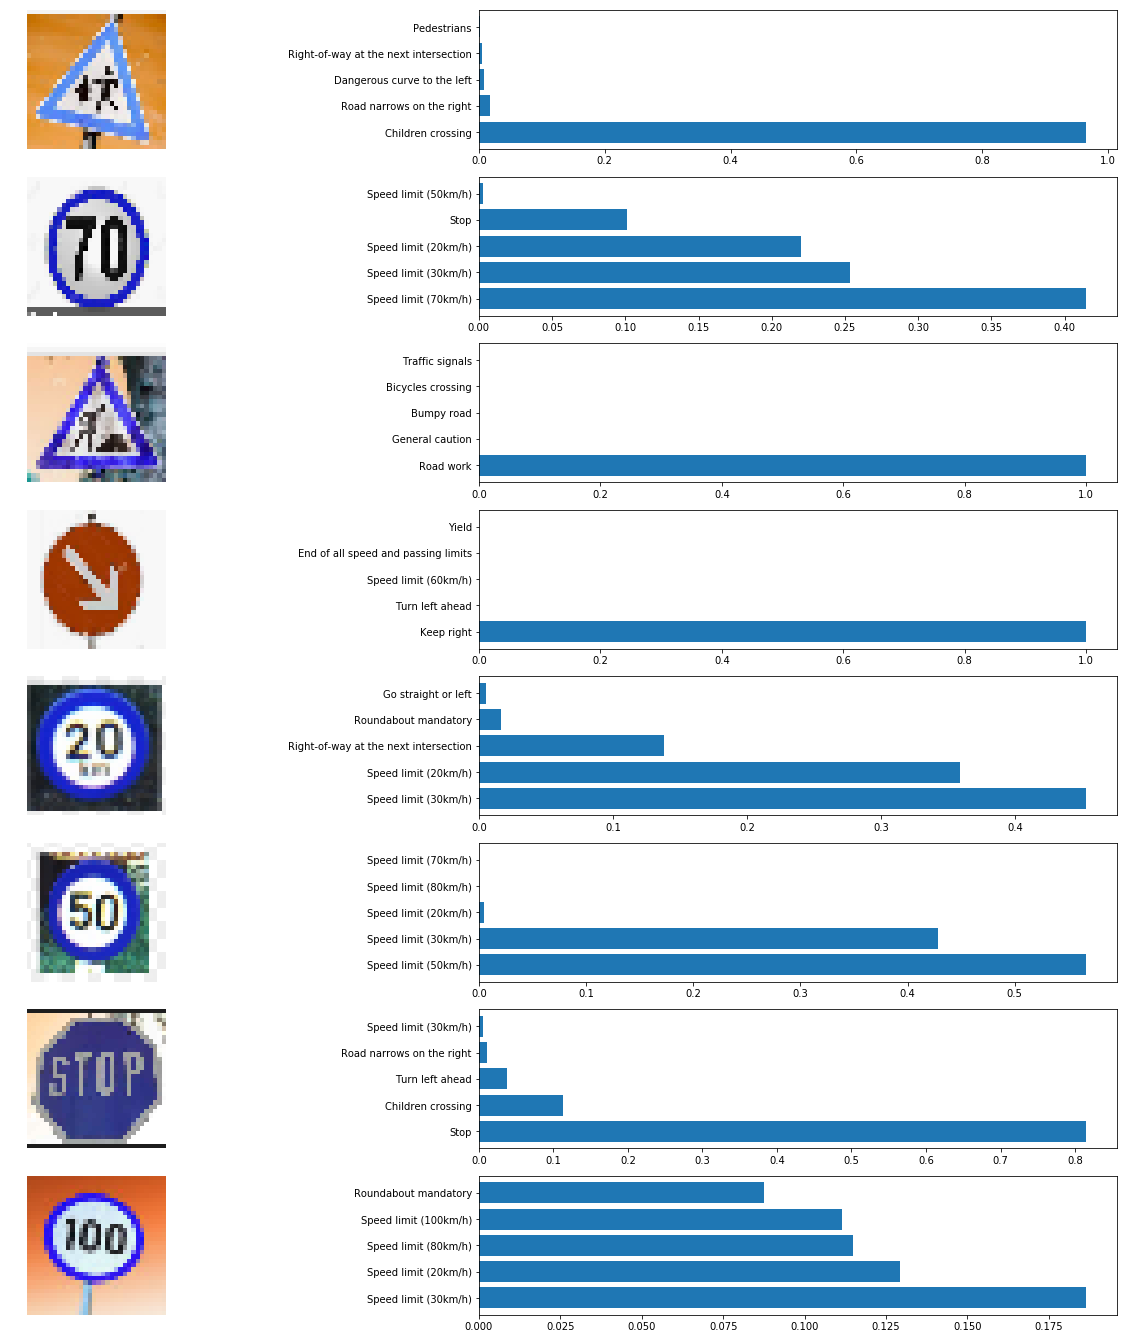

In [28]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
softmax_logits = tf.nn.softmax(logits)
top_k=tf.nn.top_k(softmax_logits,5)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    top_k = sess.run(top_k, feed_dict={x: my_X_test_preProcessed, keep_prob : 1.0})
    
    visualizeTop_k(my_X_test, X_train, top_k)
    visualizeTop_k2(my_X_test, X_train, top_k)
    
print('done')